# Enrichment of regulons from Regulons_by_strain

In [40]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)
    
import warnings

import pandas as pd
from IPython.display import display
pd.set_option('max_colwidth', 70)
pd.set_option('display.max_rows', 500)
import string
import numpy as np
import matplotlib.pyplot as plt

from orangecontrib.bioinformatics.geneset.__init__ import list_all

import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from functionsDENet import loadPickle, savePickle
import stages_DE.enrichment_library as enr
reload(enr)
import stages_DE.enrichment_library as enr

In [2]:
#Path for expression data (mergedGenes_RPKUM.tsv)
dataPath='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
#Path for regulons
pathRegulons='/home/karin/Documents/timeTrajectories/data/regulons/by_strain/kN300_mean0std1_log/'

## Used gene sets
Use gene sets that do not have less than 5 or more than 500 genes. Use all ontologies.

In [3]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
GENE_SETS_ONTOLOGY=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=True,set_sizes=(5,500))

In [4]:
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in GENE_SETS_ONTOLOGY.items():
    for s in v:
        n=len(s.genes)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in GENE_SETS_ONTOLOGY.items()})

Min size 5 Max size 440
N sets {('GO', 'molecular_function'): 35, ('Custom', 'Baylor'): 11, ('Dictybase', 'Phenotypes'): 209, ('GO', 'biological_process'): 52, ('GO', 'cellular_component'): 24, ('KEGG', 'Pathways'): 96}


In [5]:
# For conversion of gene names to EID
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
all_gene_names= genes[(genes != 0).any(axis=1)].index
NAME_EID=enr.name_genes_entrez(gene_names=all_gene_names, key_entrez=False)
ALL_GENE_NAMES_EID=enr.convert_EID(genes=all_gene_names, name_EID=NAME_EID)

In [25]:
#OLD CODE!!!!!!!!!!!!!!!!!!!
def group_diff_enrichment(data:pd.DataFrame,group:str,padj:float=0.25,min_overlap:int=None,
                          use_annotated_genes:bool=False,enrichment_map=False):
    #Displays only gene sets that have overlap with query greater or equal to min_overlap 
    #For p value and padj calculation uses alll that have overlap >=1 } from gene_set_enrichment
    """
    :param use_annotated_genes: if True use for reference and query  only genes that have at 
    least one gene set annotation
    """
    selected=list(data[data['Cluster']==group].index)
    query_EID=enr.convert_EID(genes=selected, name_EID=NAME_EID)
    print('***  '+group+' selected:',len(selected),'with EID:',len(query_EID))
    
    reference_gene_eids=ALL_GENE_NAMES_EID.copy()
    query_eids=query_EID.copy()
    
    if use_annotated_genes:
        gene_sets_genes=set()
        for gene_set_name, gene_sets in GENE_SETS_ONTOLOGY.items():
            for gene_set in gene_sets:
                gene_sets_genes.update(gene_set.genes)
        reference_gene_eids=set(reference_gene_eids) & gene_sets_genes
        query_eids=set(query_eids) & gene_sets_genes
        print('Ratio of genes annotated with a gene set in reference',
              round(len(reference_gene_eids)/len(ALL_GENE_NAMES_EID),2),
             'and query',round(len(query_eids)/len(query_EID),2))
    
    query_in_enriched=set()
    result=None
    fig,ax=None,None
    if len(query_eids) > 0:
        enrichment=enr.gene_set_enrichment(query_eids, reference_EID=reference_gene_eids, 
                                                padj_threshold=padj,min_overlap=min_overlap,
                                                gene_sets_ontology=GENE_SETS_ONTOLOGY)
        if len(enrichment)>0:
            enrichment_display=list()
            enrichment= sorted(enrichment, key=lambda data: data.padj)
            for enriched in enrichment:
                query_in_enriched.update(enriched.gene_set.genes & query_eids)
                enrichment_display.append({'Gene set':enriched.gene_set.name,
                                           'Ontology':enriched.ontology[0]+': '+enriched.ontology[1],
                                           'FDR':"{:.2e}".format(enriched.padj),'N in query':enriched.in_query,
                                           'Set size':len(enriched.gene_set.genes),
                                                          'N in ref.':enriched.in_reference})
            result=pd.DataFrame(enrichment_display)
            if enrichment_map:
                fig,ax=plt.subplots(figsize=(10,10))
                with warnings.catch_warnings(record=True):
                    enr.enrichment_map(enriched=enrichment, ax=ax,query_size=len(query_eids),
                                   fontsize=8,min_overlap=0.1)
                fig.suptitle('Group '+group+' using '+str(len(query_eids))+' out of '+str(len(selected))+
                             ' genes for enrichment calculation.')
    print('Enrichment at FDR: '+str(padj)+' and min query - gene set overlap',str(min_overlap))
    print('N query genes in displayed gene sets:',len(query_in_enriched),'out of', len(query_eids),
          'query genes used for enrichment calculation.')
    display(result)
    print('\n')
    if enrichment_map:
        return (result,(fig,ax))
    else:
        return result

## Enrichment reports

Enrichment bar plot: Query - information about the gene group of interest, Reference -information about the reference gene group. Both Query and Reference are written as "p (N)", where p is the proportion of group genes used for enrichemnt analysis that overlap with the gene set, given as percent, and N is the number of such genes. Fold enrichment is given as bars, with consistent scale across gene groups (regulons) - min = 1 and max = 100 (all individual fold enrichments are < 100). The bars are coloured based on FDR so that the colour shows -log10(FDR) with all FDRs <= 10^-10 being coloured the same (yellow). The largest FDR (0.25) is coloured violet.

Enrichment map: Circles show gene sets (as displayed in the report). Size shows the overlap between gene set and query (genes of interest) as ratio of query genes used in enrichemnt calculation (larger is more). Colour denotes padj value (smaller is more yellow), with all values below 10^-10 being assigned the same shade of yellow. Lines show overlap between gene sets as ration of genes from smaller gene set present in the larger one, encoded as line thickness. Overlaps below 0.1 were excludded from plotting. Arrows show that all genes of a samller gene set (arrow start) are contained in the larger gene set. 

In [6]:
save_enrichment=False
PADJ=0.25
MIN_OVERLAP=2
MAX_LFC_BAR=100
MIN_FDR_BAR=10**(-10)
LFDR_BASE_BAR=10
# Any colour map from https://matplotlib.org/tutorials/colors/colormaps.html
#CMAP_FDR_BAR='gnuplot'
CMAP_FDR_BAR=['#000000',"#171082", "#6d00b0",'#a1239f', "#b0003e",'#b01a00','#cc6300','#eb9202','#d4a600','#e3dc12']

Legend for fold enrichment barplots.

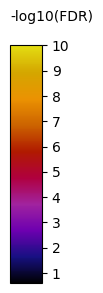

In [7]:
#Colour fold change legend
%matplotlib agg
fig,ax=enr.plot_legend_enrichment_bar(cmap=CMAP_FDR_BAR, min_FDR=MIN_FDR_BAR,used_padj=PADJ,base=LFDR_BASE_BAR)
display(fig)

### Enrichment for expression_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.pdf

In [ ]:
#Old code
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.tab',index_col=0)
for group in range(1,len(regulons['Cluster'].unique())+1):
    enriched=group_diff_enrichment(data=regulons,group='C'+str(group),min_overlap=2)
    if save_enrichment and enriched is not None:
        enriched.to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)

#### Using only genes annotated with at least one gene set 
To find genes that have gene set annotations only gene sets used in enrichment are used (see above). Genes that are in at least one of these gene sets are used for enrichment calculation, both for reference and gene group of interest (query).

***  C1 selected: 30 with EID: 30
Ratio of genes annotated with a gene set in reference 0.33 and query 0.73
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 22 query genes used for enrichment calculation.


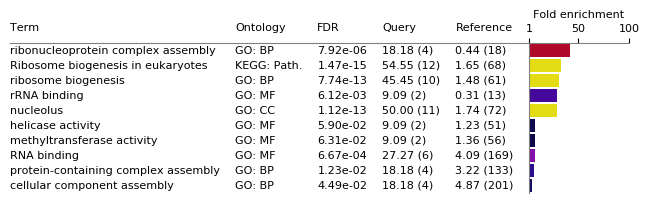

***  C2 selected: 66 with EID: 65
Ratio of genes annotated with a gene set in reference 0.33 and query 0.58
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 34 out of 38 query genes used for enrichment calculation.


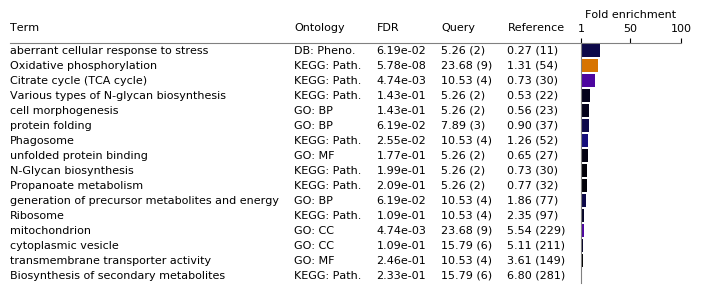

***  C3 selected: 68 with EID: 68
Ratio of genes annotated with a gene set in reference 0.33 and query 0.97
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 62 out of 66 query genes used for enrichment calculation.


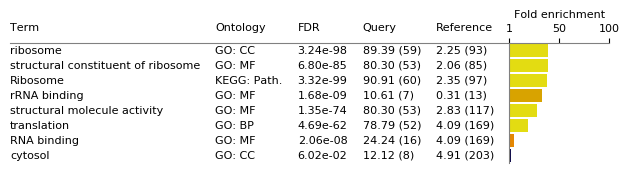

***  C4 selected: 55 with EID: 55
Ratio of genes annotated with a gene set in reference 0.33 and query 0.44
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 18 out of 24 query genes used for enrichment calculation.


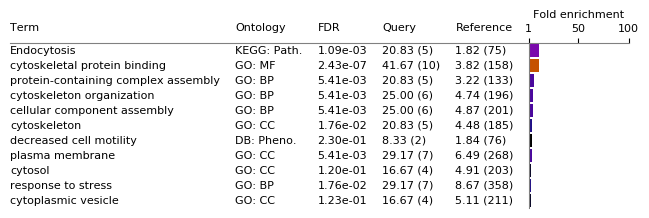

***  C5 selected: 41 with EID: 41
Ratio of genes annotated with a gene set in reference 0.33 and query 0.98
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 35 out of 40 query genes used for enrichment calculation.


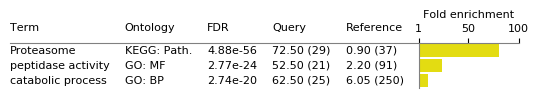

***  C6 selected: 74 with EID: 74
Ratio of genes annotated with a gene set in reference 0.33 and query 0.49
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 30 out of 36 query genes used for enrichment calculation.


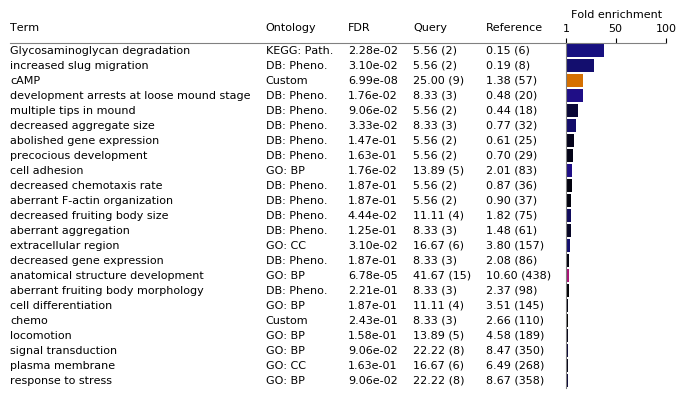

***  C7 selected: 40 with EID: 40
Ratio of genes annotated with a gene set in reference 0.33 and query 0.4
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 14 out of 16 query genes used for enrichment calculation.


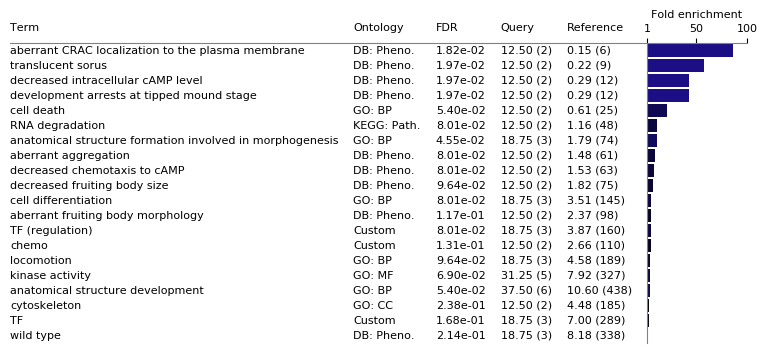

***  C8 selected: 23 with EID: 23
Ratio of genes annotated with a gene set in reference 0.33 and query 0.26
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 3 out of 6 query genes used for enrichment calculation.


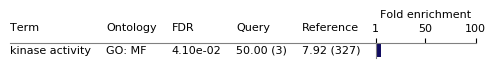

***  C9 selected: 20 with EID: 20
Ratio of genes annotated with a gene set in reference 0.33 and query 0.5
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 10 out of 10 query genes used for enrichment calculation.


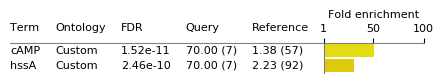

***  C10 selected: 36 with EID: 36
Ratio of genes annotated with a gene set in reference 0.33 and query 0.58
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 21 query genes used for enrichment calculation.


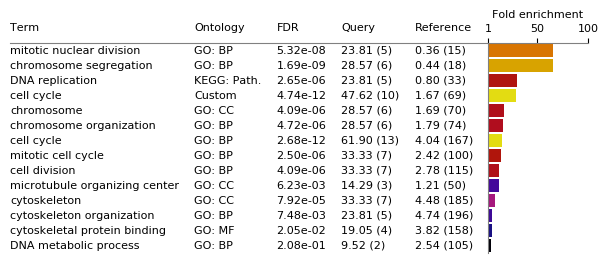

***  C11 selected: 77 with EID: 77
Ratio of genes annotated with a gene set in reference 0.33 and query 0.32
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 14 out of 25 query genes used for enrichment calculation.


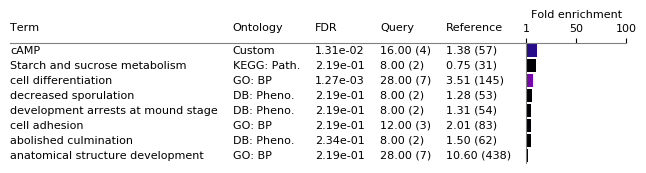

***  C12 selected: 57 with EID: 57
Ratio of genes annotated with a gene set in reference 0.33 and query 0.28
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 11 out of 16 query genes used for enrichment calculation.


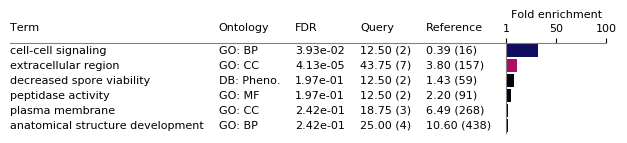

***  C13 selected: 64 with EID: 64
Ratio of genes annotated with a gene set in reference 0.33 and query 0.47
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 25 out of 30 query genes used for enrichment calculation.


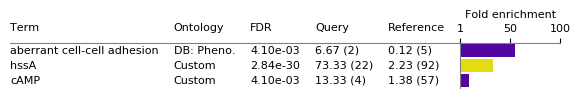

***  C14 selected: 19 with EID: 19
Ratio of genes annotated with a gene set in reference 0.33 and query 0.74
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 13 out of 14 query genes used for enrichment calculation.


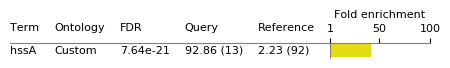

***  C15 selected: 91 with EID: 91
Ratio of genes annotated with a gene set in reference 0.33 and query 0.46
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 29 out of 42 query genes used for enrichment calculation.


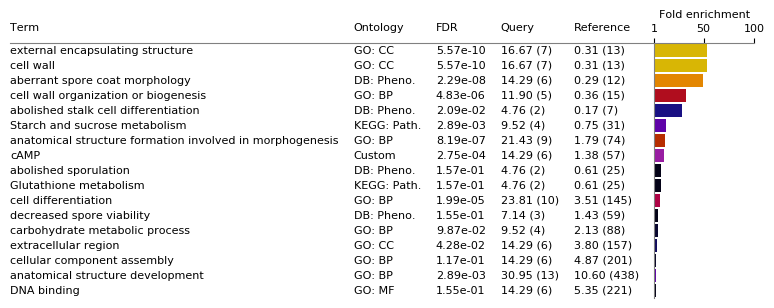

***  C16 selected: 74 with EID: 74
Ratio of genes annotated with a gene set in reference 0.33 and query 0.27
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 18 out of 20 query genes used for enrichment calculation.


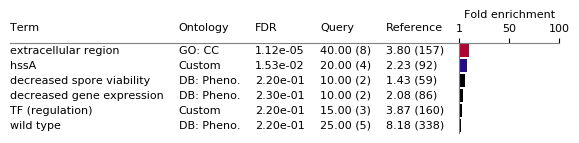

***  C17 selected: 61 with EID: 59
Ratio of genes annotated with a gene set in reference 0.33 and query 0.22
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 13 query genes used for enrichment calculation.


None

***  C18 selected: 46 with EID: 45
Ratio of genes annotated with a gene set in reference 0.33 and query 0.33
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 10 out of 15 query genes used for enrichment calculation.


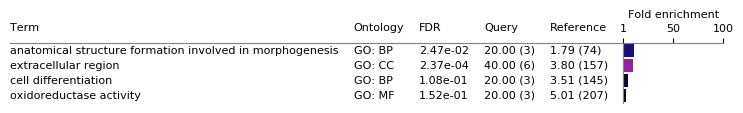

***  C19 selected: 58 with EID: 58
Ratio of genes annotated with a gene set in reference 0.33 and query 0.26
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 13 out of 15 query genes used for enrichment calculation.


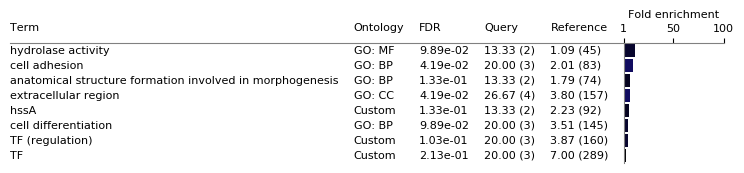

***  C20 selected: 54 with EID: 54
Ratio of genes annotated with a gene set in reference 0.33 and query 0.24
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 6 out of 13 query genes used for enrichment calculation.


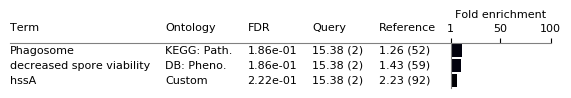

***  C21 selected: 45 with EID: 45
Ratio of genes annotated with a gene set in reference 0.33 and query 0.13
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 4 out of 6 query genes used for enrichment calculation.


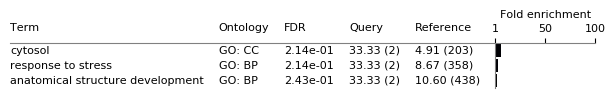

In [41]:
%matplotlib agg
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.tab',index_col=0)
figs=[]
for group in range(1,len(regulons['Cluster'].unique())+1):
#for group in [1,2]:
    enriched=enr.group_diff_enrichment(query_names=list(regulons.query('Cluster =="'+'C'+str(group)+'"').index),
                                       group='C'+str(group),
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_lFC_bar=MAX_LFC_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
    if  save_enrichment and enriched is not None:
        enriched[0].to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30_annotatedOnly_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)

##### Enrichment map for all based regulons using only genes annotated with gene sets

In [ ]:
for fig,ax in figs:
    display(fig)

### Enrichment for mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab

In [ ]:
#Old code
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab',index_col=0)
for group in range(1,len(regulons['Cluster'].unique())+1):
    cluster='C'+str(group)
    print('*** Cluster %s (%s)' %(cluster,string.ascii_uppercase[group-1]))
    enriched=group_diff_enrichment(data=regulons,group=cluster,min_overlap=2)
    if  save_enrichment and enriched is not None:
        enriched.to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)

#### Using only genes annotated with at least one gene set

*** Cluster C1 (A)
***  C1 selected: 31 with EID: 31
Ratio of genes annotated with a gene set in reference 0.33 and query 0.74
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 23 query genes used for enrichment calculation.


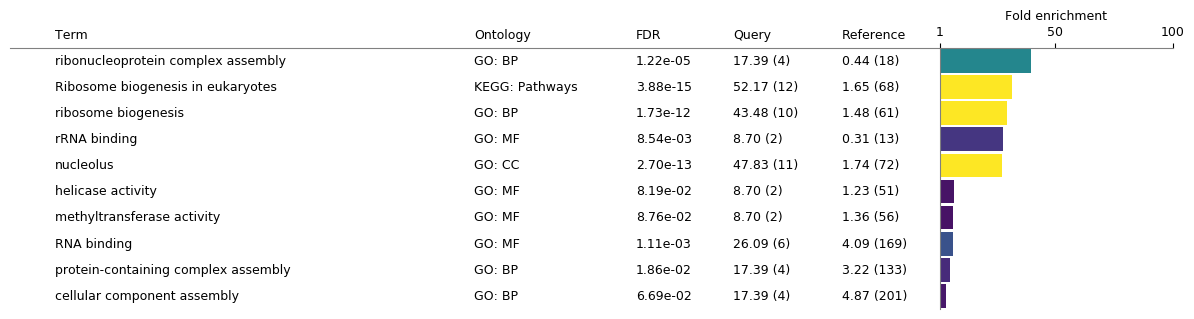

*** Cluster C2 (B)
***  C2 selected: 54 with EID: 54
Ratio of genes annotated with a gene set in reference 0.33 and query 0.57
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 24 out of 31 query genes used for enrichment calculation.


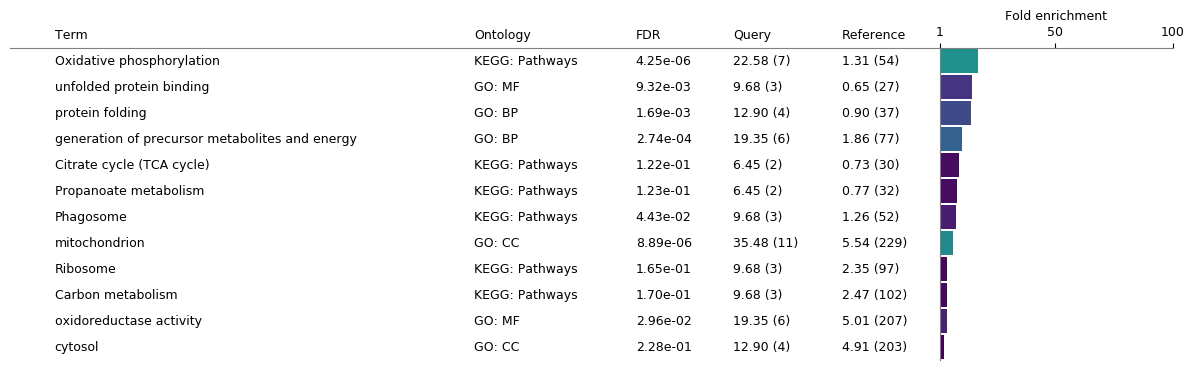

*** Cluster C3 (C)
***  C3 selected: 54 with EID: 54
Ratio of genes annotated with a gene set in reference 0.33 and query 0.89
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 44 out of 48 query genes used for enrichment calculation.


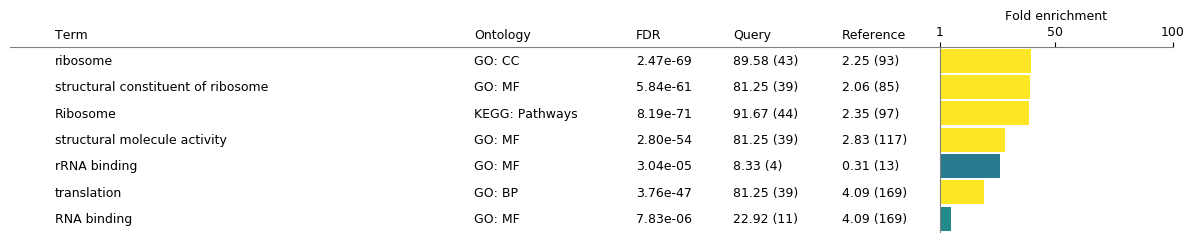

*** Cluster C4 (D)
***  C4 selected: 43 with EID: 43
Ratio of genes annotated with a gene set in reference 0.33 and query 0.51
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 22 query genes used for enrichment calculation.


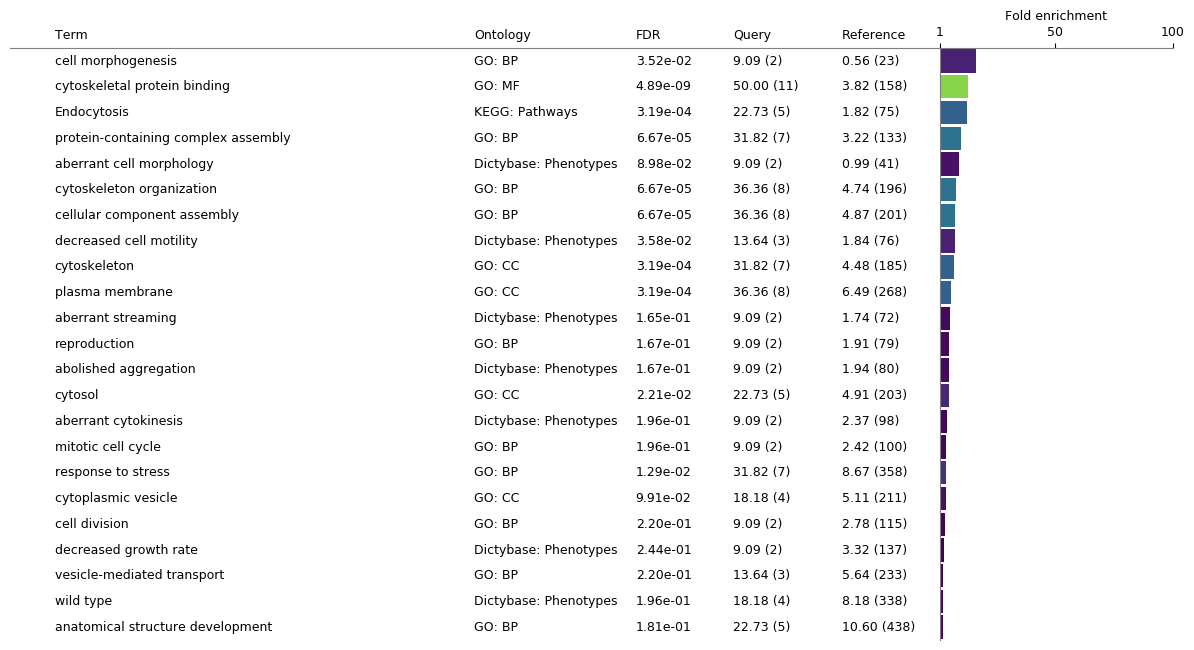

*** Cluster C5 (E)
***  C5 selected: 20 with EID: 20
Ratio of genes annotated with a gene set in reference 0.33 and query 0.9
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 18 out of 18 query genes used for enrichment calculation.


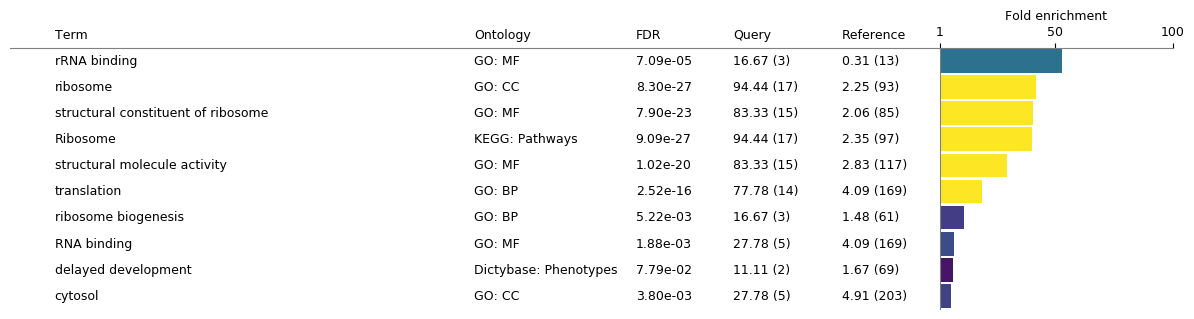

*** Cluster C6 (F)
***  C6 selected: 49 with EID: 49
Ratio of genes annotated with a gene set in reference 0.33 and query 0.94
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 35 out of 46 query genes used for enrichment calculation.


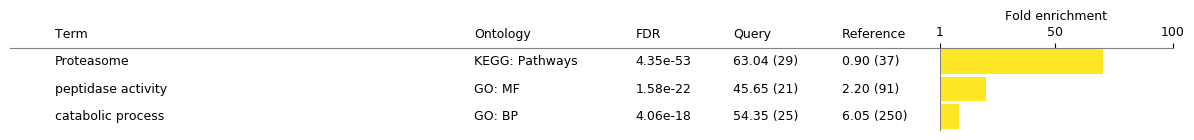

*** Cluster C7 (G)
***  C7 selected: 96 with EID: 96
Ratio of genes annotated with a gene set in reference 0.33 and query 0.44
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 36 out of 42 query genes used for enrichment calculation.


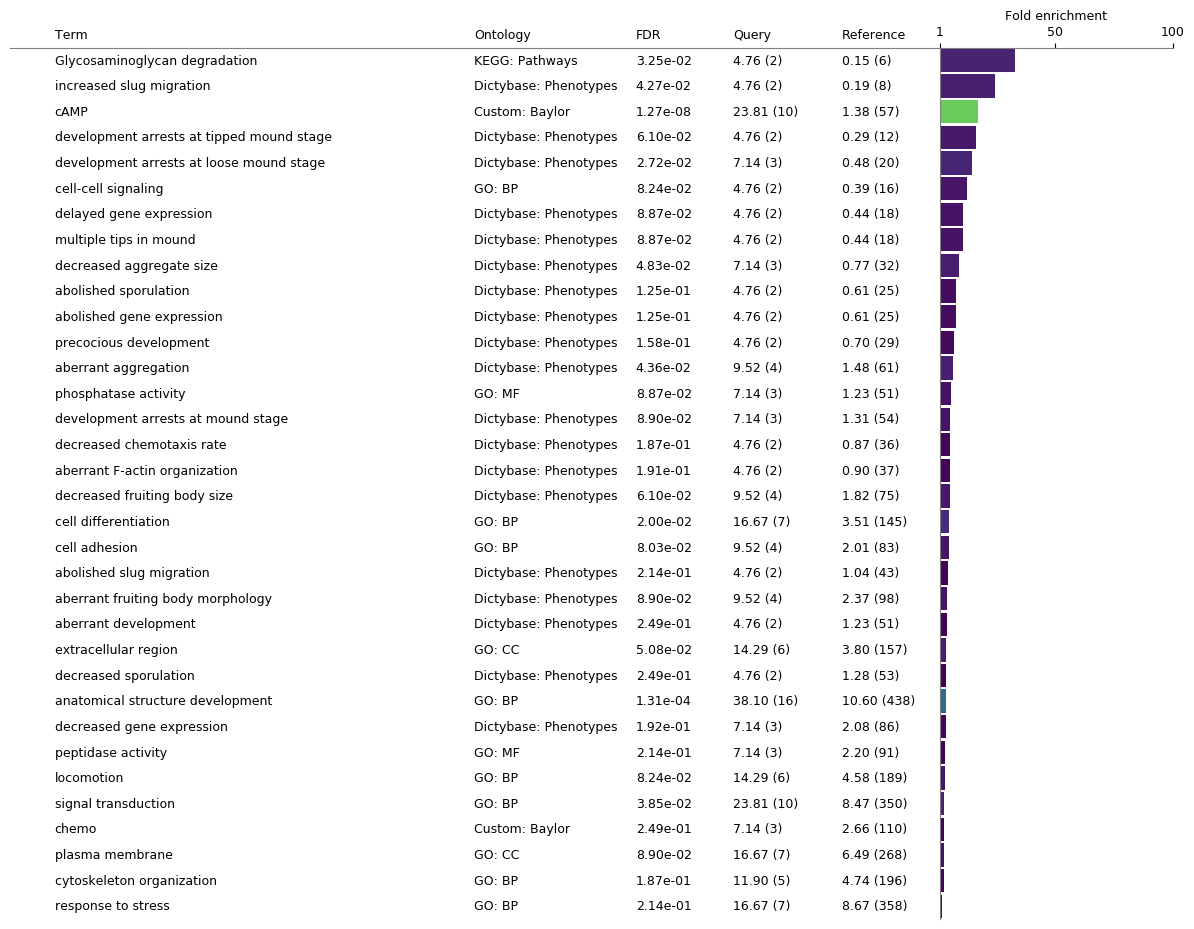

*** Cluster C8 (H)
***  C8 selected: 35 with EID: 35
Ratio of genes annotated with a gene set in reference 0.33 and query 0.43
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 13 out of 15 query genes used for enrichment calculation.


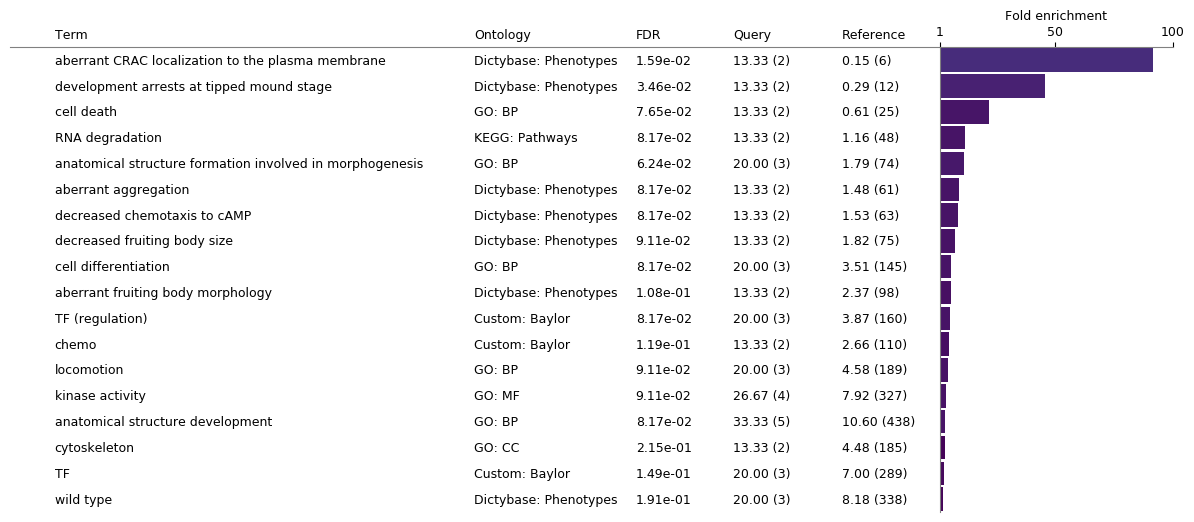

*** Cluster C9 (I)
***  C9 selected: 38 with EID: 38
Ratio of genes annotated with a gene set in reference 0.33 and query 0.55
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 21 query genes used for enrichment calculation.


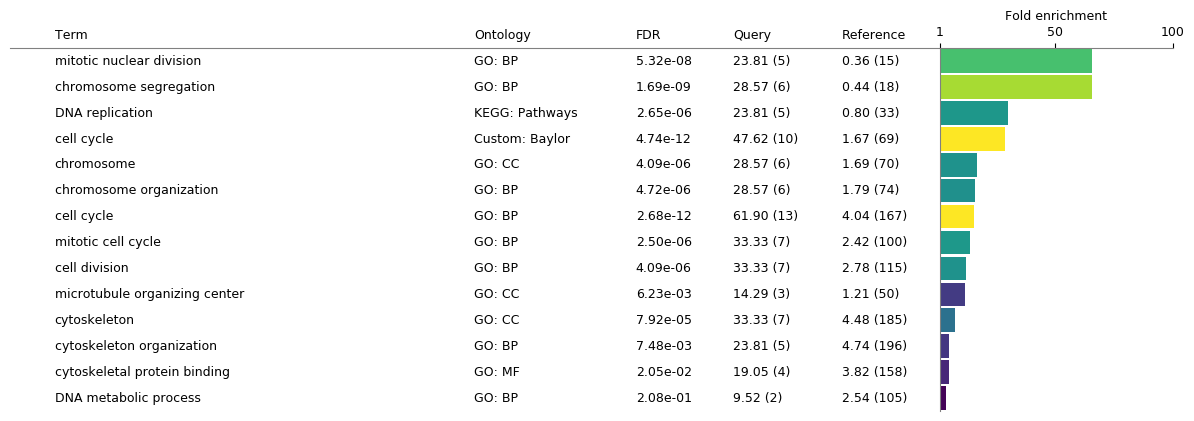

*** Cluster C10 (J)
***  C10 selected: 70 with EID: 70
Ratio of genes annotated with a gene set in reference 0.33 and query 0.27
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 14 out of 19 query genes used for enrichment calculation.


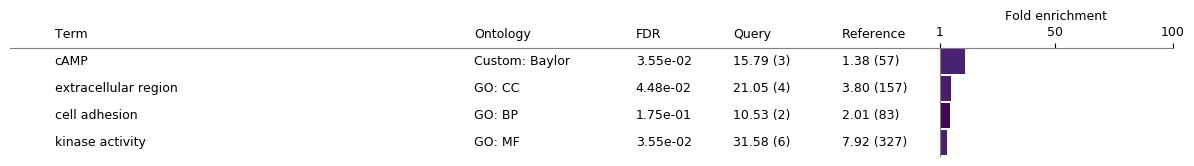

*** Cluster C11 (K)
***  C11 selected: 85 with EID: 85
Ratio of genes annotated with a gene set in reference 0.33 and query 0.39
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 19 out of 33 query genes used for enrichment calculation.


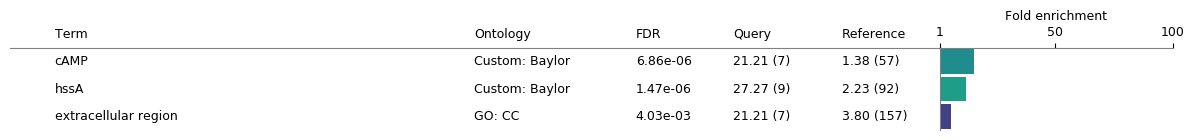

*** Cluster C12 (L)
***  C12 selected: 73 with EID: 73
Ratio of genes annotated with a gene set in reference 0.33 and query 0.53
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 36 out of 39 query genes used for enrichment calculation.


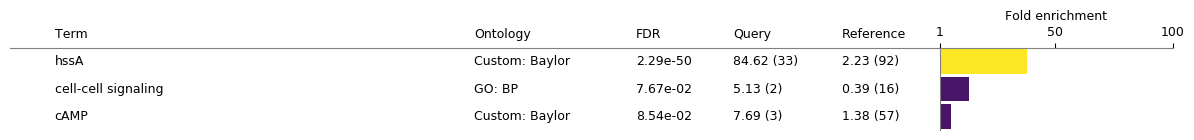

*** Cluster C13 (M)
***  C13 selected: 49 with EID: 49
Ratio of genes annotated with a gene set in reference 0.33 and query 0.35
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 15 out of 17 query genes used for enrichment calculation.


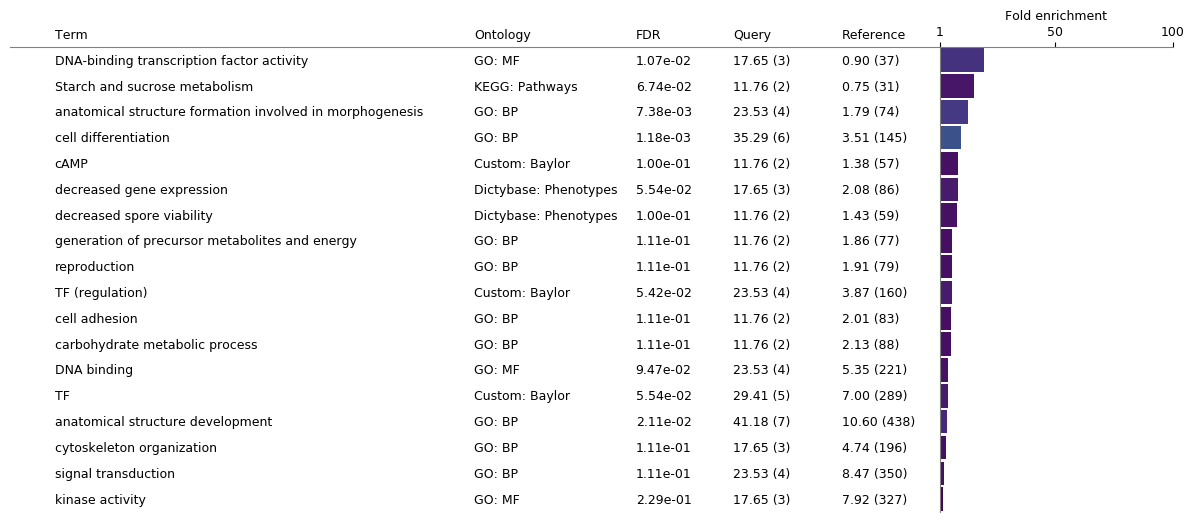

*** Cluster C14 (N)
***  C14 selected: 87 with EID: 87
Ratio of genes annotated with a gene set in reference 0.33 and query 0.47
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 34 out of 41 query genes used for enrichment calculation.


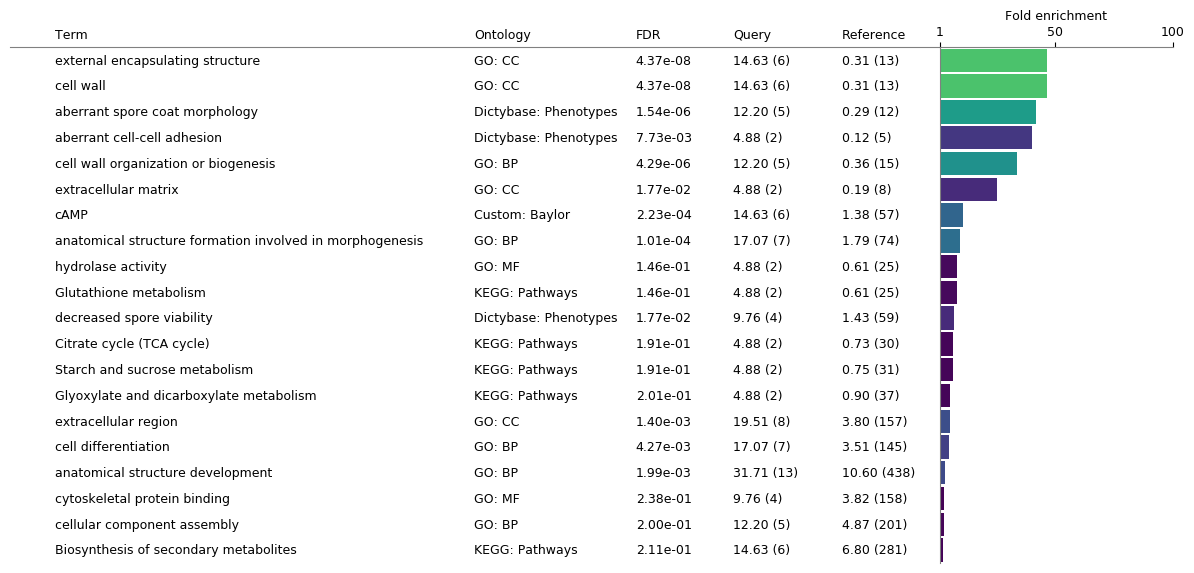

*** Cluster C15 (O)
***  C15 selected: 31 with EID: 31
Ratio of genes annotated with a gene set in reference 0.33 and query 0.29
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 4 out of 9 query genes used for enrichment calculation.


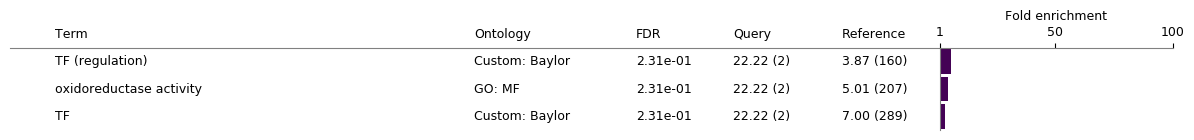

*** Cluster C16 (P)
***  C16 selected: 72 with EID: 72
Ratio of genes annotated with a gene set in reference 0.33 and query 0.29
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 14 out of 21 query genes used for enrichment calculation.


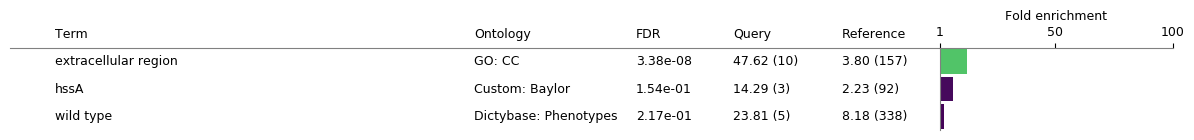

*** Cluster C17 (Q)
***  C17 selected: 57 with EID: 56
Ratio of genes annotated with a gene set in reference 0.33 and query 0.21
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 6 out of 12 query genes used for enrichment calculation.


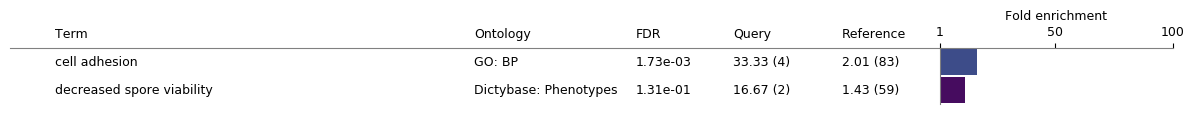

*** Cluster C18 (R)
***  C18 selected: 65 with EID: 63
Ratio of genes annotated with a gene set in reference 0.33 and query 0.19
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 11 out of 12 query genes used for enrichment calculation.


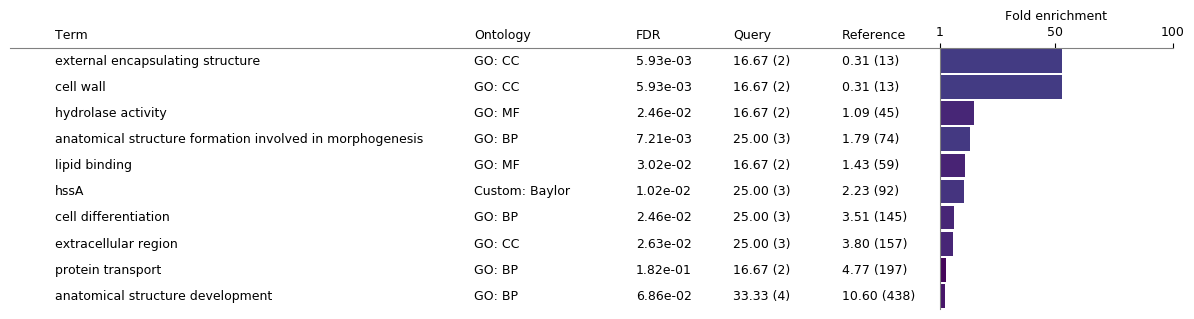

*** Cluster C19 (S)
***  C19 selected: 89 with EID: 88
Ratio of genes annotated with a gene set in reference 0.33 and query 0.22
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 10 out of 19 query genes used for enrichment calculation.


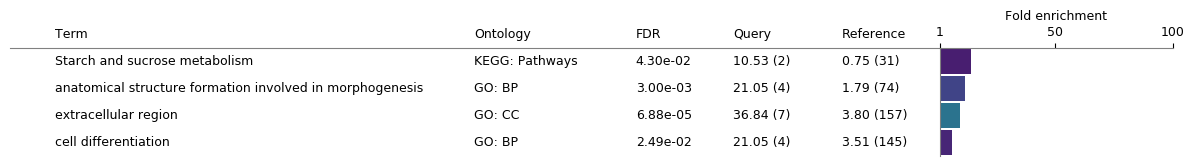

*** Cluster C20 (T)
***  C20 selected: 1 with EID: 1
Ratio of genes annotated with a gene set in reference 0.33 and query 0.0
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 0 query genes used for enrichment calculation.


None

In [9]:
%matplotlib agg
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab',index_col=0)
figs=[]
for group in range(1,len(regulons['Cluster'].unique())+1):
#for group in [1,2]:
    cluster='C'+str(group)
    print('*** Cluster %s (%s)' %(cluster,string.ascii_uppercase[group-1]))
    enriched=enr.group_diff_enrichment(query_names=list(regulons.query('Cluster =="'+'C'+str(group)+'"').index),
                                       group=cluster,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_lFC_bar=MAX_LFC_BAR, min_FDR_bar=MIN_FDR_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
    if  save_enrichment and enriched is not None:
        enriched[0].to_csv(pathRegulons+'enrichment/mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log'+str(group)+'.tsv', sep='\t',index=False)

##### Enrichment map for AX4 based regulons using only genes annotated with gene sets

In [ ]:
for fig,ax in figs:
    display(fig)

#### Use all GO gene sets (not only slims)

In [ ]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
gene_sets_ontology=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=False,set_sizes=(5,500))
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in gene_sets_ontology.items():
    for s in v:
        n=len(s.genes)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in gene_sets_ontology.items()},'\n')

%matplotlib agg
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab',index_col=0)
figs=[]
for group in range(1,len(regulons['Cluster'].unique())+1):
#for group in [1,2]:
    cluster='C'+str(group)
    print('*** Cluster %s (%s)' %(cluster,string.ascii_uppercase[group-1]))
    enriched=enr.group_diff_enrichment(query_names=list(regulons.query('Cluster =="'+'C'+str(group)+'"').index),
                                       group=cluster,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=gene_sets_ontology,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_lFC_bar=MAX_LFC_BAR, max_lFDR_bar=MAX_LFDR_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])